In [389]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter('ignore')
palette = sns.husl_palette(s=1)
sns.set(style='whitegrid', palette=palette, context='talk')

### Feature Engineering Function

In [390]:
def feat_eng(X):
    # Create additional features
    X_t = X
    X_t['atemp_shift'] = abs(X_t['atemp'] - 35)
    X_t['datetime'] = pd.to_datetime(X_t['datetime'])
    # Extract all time information
    X_t['datetime_hour'] = X_t['datetime'].dt.hour # important _ onehot
    X_t['datetime_day'] = X_t['datetime'].dt.day
    X_t['datetime_month'] = X_t['datetime'].dt.month # use month as onehot or factorized instead of season
    X_t['datetime_year'] = X_t['datetime'].dt.year # maybe instead of timestamp
    X_t['datetime_weekdays'] = X['datetime'].dt.day_name()
    X_t['timestamp'] = X_t['datetime'].astype(int) / 1_000_000_000_000_000_000
    X_t['hour_workday'] = X_t['datetime_hour'] * X_t['workingday']
    X_t['hour_weekend'] = X_t['datetime_hour'] * (X_t['workingday'] - 1) * (-1)
    return X_t

### Load data

In [391]:
df = pd.read_csv('train.csv', parse_dates=True)
df_test = pd.read_csv('test.csv', parse_dates=True)

### Train-test-split

In [392]:
X = df.copy()
X_test = df_test.copy()
y = df['count'].values

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=4)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

X_train.reset_index(inplace=True)
X_train_stored = X_train.copy()
X_val.reset_index(inplace=True)
X_test.reset_index(inplace=True)
X.reset_index(inplace=True)

y_train_cas = X_train['casual']
y_train_reg = X_train['registered']
y_cas = X['casual']
y_reg = X['registered']

In [393]:
# Feature Engineer
X_train = feat_eng(X_train)
X_val = feat_eng(X_val)
X_test = feat_eng(X_test)
X = feat_eng(X)

In [394]:
# One-Hot-Encoding
from sklearn.preprocessing import OneHotEncoder
ohc = OneHotEncoder(sparse=False, drop='first')
onehot_features = ['datetime_month', 'weather', 'hour_workday', 'hour_weekend']
ohc.fit(X_train[onehot_features])
onehot_columns = ohc.get_feature_names(['month', 'weather', 'hour_workday', 'hour_weekend'])

# Make dataframes of one-hot-encoded features and give column names
X_train_onehot = ohc.transform(X_train[onehot_features])
X_train_onehot = pd.DataFrame(X_train_onehot, columns=onehot_columns)

X_val_onehot = ohc.transform(X_val[onehot_features])
X_val_onehot = pd.DataFrame(X_val_onehot, columns=onehot_columns)

X_test_onehot = ohc.transform(X_test[onehot_features])
X_test_onehot = pd.DataFrame(X_test_onehot, columns=onehot_columns)

X_onehot = ohc.transform(X[onehot_features])
X_onehot = pd.DataFrame(X_onehot, columns=onehot_columns)

In [395]:
# Select features from original data and concatenate with one-hot-encoded features
features = ['timestamp', 'atemp_shift', 'humidity', 'windspeed']

X_train = X_train[features]
X_train = pd.concat([X_train, X_train_onehot], axis=1)

X_val = X_val[features]
X_val = pd.concat([X_val, X_val_onehot], axis=1)

X_test = X_test[features]
X_test = pd.concat([X_test, X_test_onehot], axis=1)

X = X[features]
X = pd.concat([X, X_onehot], axis=1)

## Set up the model

In [396]:
from sklearn.linear_model import LinearRegression

In [397]:
lr_cas = LinearRegression()
lr_cas.fit(X_train, np.log(y_train_cas+1))
lr_cas.score(X_train, np.log(y_train_cas+1))

0.8534126561520876

In [398]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, np.log(y_train_reg+1))
lr_reg.score(X_train, np.log(y_train_reg+1))

0.9361678533220528

Cross validation

In [399]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lr_reg, X_train, np.log(y_train_reg+1), cv=4, scoring='r2')
scores

array([-1.87668239e+17,  9.33443111e-01,  9.30829696e-01,  9.35466294e-01])

In [400]:
scores.mean().round(3), scores.std().round(3)

(-4.691705982913447e+16, 8.12627313658097e+16)

In [401]:
y_pred_cas = np.exp(lr_cas.predict(X_train))
y_pred_reg = np.exp(lr_reg.predict(X_train))
y_pred_count = y_pred_cas + y_pred_reg

In [402]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

print('Score for training data')
print('R2 value: ' + str(r2_score(y_train, y_pred_count)))
print('RMSLE: ' + str(np.sqrt(mean_squared_log_error(y_train, y_pred_count))))

Score for training data
R2 value: 0.9056470567261048
RMSLE: 0.37070959239040097


In [403]:
#lr_reg.coef_, lr_cas.coef_

In [404]:
count_residual = y_pred_count - y_train

In [405]:
result = pd.DataFrame({'y_train':y_train, 'y_pred_count':y_pred_count, 'y_count_residual':count_residual})

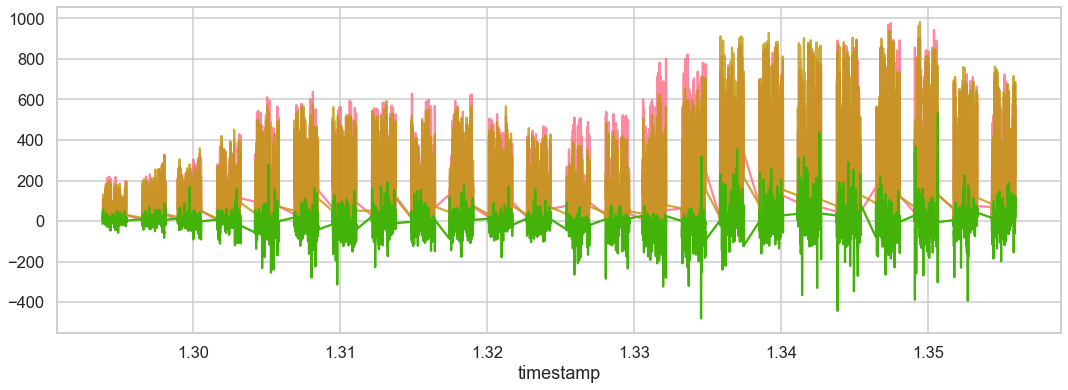

In [406]:
fig = plt.figure(figsize=(18,6))
ax = sns.lineplot(x='timestamp', y=y_train, data=X_train, alpha = 0.8)
ax = sns.lineplot(x='timestamp', y=y_pred_count, data=X_train, alpha = 0.8)
ax = sns.lineplot(x='timestamp', y=count_residual, data=X_train)
#ax.set_xlim(pd.Timestamp('2011-04-01'), pd.Timestamp('2011-09-01'))

[Text(0.5, 0, 'Count')]

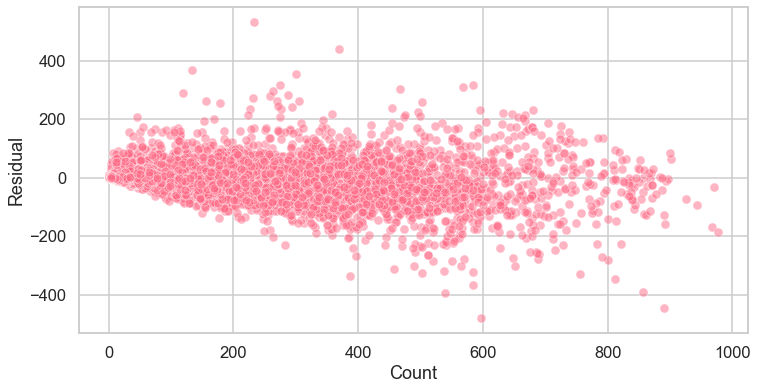

In [408]:
fig = plt.figure(figsize=(12,6))
ax = sns.scatterplot(x=y_train, y=count_residual, data=X_train, alpha = 0.5)

ax.set(ylabel='Residual')
ax.set(xlabel='Count')

[Text(0.5, 0, '"Feels like" temperature / °C')]

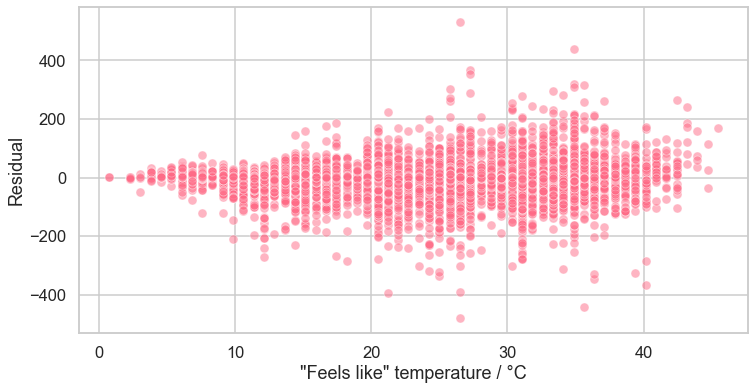

In [409]:
fig = plt.figure(figsize=(12,6))
ax = sns.scatterplot(x='atemp', y=count_residual, data=X_train_stored, alpha = 0.5)

ax.set(ylabel='Residual')
ax.set(xlabel='"Feels like" temperature / °C')

In [348]:
#X_train[count_residual > 300]

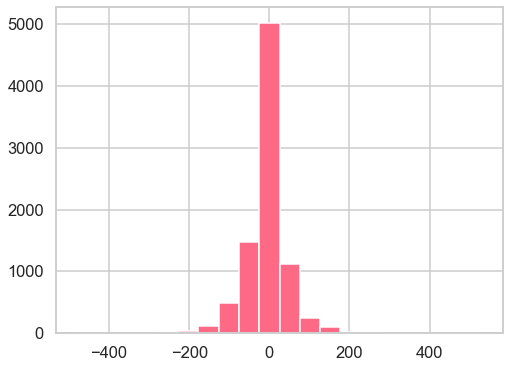

In [410]:
# check if residuals are normally distributed

fig = plt.figure(figsize=(8,6))
result['y_count_residual'].hist(bins=20)

((array([-3.77627465, -3.5491955 , -3.42443716, ...,  3.42443716,
          3.5491955 ,  3.77627465]),
  array([-480.71241625, -443.41703397, -393.04357793, ...,  368.34676129,
          438.41070008,  531.79841585])),
 (51.752478706395216, -5.54605368918246, 0.9372552498704909))

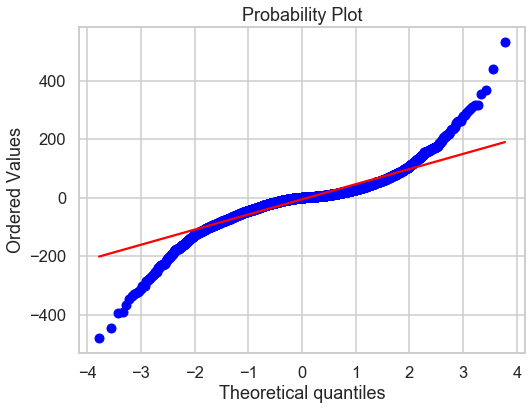

In [411]:
# Probplot - residuals should be a straight line

from scipy.stats import probplot
fig = plt.figure(figsize=(8,6))
probplot(result['y_count_residual'], plot=plt)

In [412]:
# Jarque Bera Test (returns test statistic and p-value, both values should be low)

from scipy.stats import jarque_bera
jarque_bera(result['y_count_residual'])

(27506.867088070805, 0.0)

In [413]:
# Variance Inflation Factor (VIF) to measure multicolinearity. A VIF greater than 5 indicates high multicolinearity.

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X_train = add_constant(X_train)
VIF= pd.Series([variance_inflation_factor(X_train.values, i)
        for i in range(X_train.shape[1])],
        index=X_train.columns)

VIF.sort_values(ascending=False)

const             7353.321875
atemp_shift          4.232665
month_7              3.992806
month_8              3.962405
month_6              3.591273
                     ...     
hour_weekend_6       1.285049
weather_3            1.269999
windspeed            1.195412
weather_2            1.181142
weather_4            1.006905
Length: 65, dtype: float64

## Score of validation data

In [349]:
# Score on validation data!

y_pred_cas_val = np.exp(lr_cas.predict(X_val))
y_pred_reg_val = np.exp(lr_reg.predict(X_val))
y_pred_count_val = y_pred_cas_val + y_pred_reg_val

print('Score for validation data')
print('R2 value: ' + str(r2_score(y_val, y_pred_count_val)))
print('RMSLE: ' + str(np.sqrt(mean_squared_log_error(y_val, y_pred_count_val))))

Score for validation data
R2 value: 0.9094347611296428
RMSLE: 0.37360451222782737


## Train on whole dataset

In [304]:
lr_cas.fit(X, np.log(y_cas+1))
lr_reg.fit(X, np.log(y_reg+1))

lr_cas.score(X, np.log(y_cas+1)), lr_reg.score(X, np.log(y_reg+1))

(0.8571658130011657, 0.9396705910909932)

## Predict values for test data

In [305]:
y_pred_cas_test = np.exp(lr_cas.predict(X_test))
y_pred_reg_test = np.exp(lr_reg.predict(X_test))
y_pred_count_test = y_pred_cas_test + y_pred_reg_test

In [306]:
y_pred_count_test 

array([ 11.57401408,   6.19387451,   3.53668921, ..., 211.54986813,
       165.30391092, 103.07906345])

In [308]:
Kaggle_LinReg01 = pd.DataFrame({'datetime': df_test['datetime'], 'count': y_pred_count_test})
Kaggle_LinReg01.to_csv('Kaggle_LinReg01.csv', index=False)

In [309]:
Kaggle_LinReg01

,datetime,count
0,2011-01-20 00:00:00,11.574014
1,2011-01-20 01:00:00,6.193875
2,2011-01-20 02:00:00,3.536689
3,2011-01-20 03:00:00,2.386467
4,2011-01-20 04:00:00,2.639669
...,...,...
6488,2012-12-31 19:00:00,367.713930
6489,2012-12-31 20:00:00,262.110380
6490,2012-12-31 21:00:00,211.549868
6491,2012-12-31 22:00:00,165.303911


#### Scale the data

In [57]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() # scales each column to minimum 0.0 and maximum 1.0. Makes sure all data fits together.
scaler.fit(X_train)

X_train = scaler.transform(X_train) # later just use transform on X_test, DO NOT FIT AGAIN
X_val = scaler.transform(X_val)

X_train.head()#.shape, X_val.shape

AttributeError: 'numpy.ndarray' object has no attribute 'head'